# The relationship between Zn and diabetes
- Author: Yiran Jing
- Date: 25 Oct




## Data Cleaning:
- Modify DIABBC = 1 to DIABBC = Yes; DIABBC = 5 to DIABBC = No
- remove missing values ???好像没做。
- remove outliers：
   - For the exercise time, if the exercise time > 1500 mins/week, trade as outlisers, set the value to 0
- remove children (age < 18)
- remove currently pregnant (sabdyms = 4)
- remove the group DIABBC = 3 as too few people in this group

### Data SetDescription:

#### Response
**DIABBC**:
Only diabetes currently and healthy(never has diabetes) are presented here. relatively few diabetes quit and these observations (around 50 ppl) have been excluded from the data
  
- Yes(1) : Ever told has diabetes mellitus, still current and long term
- No(0) : Never told has diabetes mellitus


#### Key variable description




## Contents:

Todo 还没写






# Key findings: 需要修改
1. The dirtribution of Zn conditional on Sex looks different!
2. The column ZINCT1, ZINCT2, and ZINCT_MEAN has quite similar distribution. So it **make sense to use ZINCT_MEAN only in our following analysis**.
3. **Vegan indicator didnot have enough samples**: Under Vegan indacator, only 17 ppl are vegan, and 1 of them has diabetes. Too less sample.
4. **The no red meat group has less risk to get diabetes, compared to the group eating red meat**:
    - Under Red Meat indicator, 5.3% diabetes in the group "no-red meat eating", 7% diabetes in the group "eating red meat"
5. **DIETRDI(Whether vegetable and fruit consumption met recommended guidelines) cannot help our analsis**.  

  

### Other findings:
1. The correlation matrix is useless (correlation/linear relationship is quite low), so I removed it. 

In [1]:
import pandas as pd
import pyspark
from datetime import datetime
import os.path 
import datetime
pd.set_option('display.max_columns', 500)
import seaborn as sns
import numpy as np
import calendar
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
from scipy.stats import norm, skew
import statsmodels.api as sm
blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import nltk
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

In /Users/yiranjing/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/yiranjing/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/yiranjing/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/yiranjing/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/yiranjing/miniconda3/lib/pytho

#### Load dataset

In [18]:
merged_food_nutr_binom = pd.read_csv('data/cleaned_all_14Oct.csv')

In [19]:
merged_food_nutr_binom.head()

,ABSPID,BMISC,AGEC,SMSBC,COBBC,FEMLSBC,PHDKGWBC,PHDCMHBC,EXLWTBC,EXLWMBC,EXLWVBC,PHDCMWBC,SF2SA1QN,INCDEC,DIABBC,HCHOLBC,HSUGBC,HYPBC,ADTOTSE,BDYMSQ04,DIASTOL,DIETQ12,DIETQ14,DIETQ5,DIETQ8,DIETRDI,SABDYMS,SEX,SLPTIME,SMKDAILY,SMKSTAT,SYSTOL,ALTNTR,ALTRESB,APOBNTR,APOBRESB,B12RESB,BIORESPC,CHOLNTR,CHOLRESB,CVDMEDST,DIAHBRSK,FASTSTAD,FOLATREB,GGTNTR,GGTRESB,GLUCFPD,GLUCFREB,HBA1PREB,HDLCHREB,LDLNTR,LDLRESB,TRIGNTR,TRIGRESB,BMISC_MISS,SMSBC_MISS,FEMLSBC_MISS,PHDKGWBC_MISS,PHDCMHBC_MISS,PHDCMWBC_MISS,INCDEC_MISS,ADTOTSE_MISS,BDYMSQ04_MISS,DIASTOL_MISS,DIETQ12_MISS,DIETQ14_MISS,DIETRDI_MISS,SABDYMS_MISS,SLPTIME_MISS,SMKDAILY_MISS,SMKSTAT_MISS,SYSTOL_MISS,ALTNTR_MISS,ALTRESB_MISS,APOBNTR_MISS,APOBRESB_MISS,B12RESB_MISS,BIORESPC_MISS,CHOLNTR_MISS,CHOLRESB_MISS,CVDMEDST_MISS,DIAHBRSK_MISS,FASTSTAD_MISS,FOLATREB_MISS,GGTNTR_MISS,GGTRESB_MISS,GLUCFPD_MISS,GLUCFREB_MISS,HBA1PREB_MISS,HDLCHREB_MISS,LDLNTR_MISS,LDLRESB_MISS,TRIGNTR_MISS,TRIGRESB_MISS,ABSHID,GRAMWGT,FOODCODC,ENERGYWF,ENERGYNF,MOISTURE,PROTEIN,FATG,CHOWSA,CHOWOSA,STARCH,SUGARS,FIBRE,ALCOHOL,PREVITA,PROVITA,RETEQV,B1MG,B2MG,B3MG,NIACINEQ,FOLATEUG,FOLACID,TOTFOL,FOLATEQV,B6MG,B12UG,VITCMG,VITEMG,CALMG,IODINEUG,IRONMG,MAGMG,PHOSMG,POTASMG,SELUG,SODMG,ZINCMG,CAFFMG,CHOLMG,SFAG,MUFAG,PUFAG,LAG,ALAG,LCN3MG,TRANSMG,COMBCODE,EATTIMEC,EATOCC,DAYNUM,TWDIG,THRDIG,FIVDIG,DISCFLG,GRNSRV,WGSRV,WGBRSRV,WGGNSRV,WGOASRV,WGBFSRV,WGSVSRV,WGCRSRV,WGMFSRV,WGFLSRV,RFGRSRV,RFBRSRV,RFGNSRV,RFOASRV,RFBFSRV,RFSVSRV,RFCRSRV,RFMFSRV,RFFLSRV,VEGSRV,VGGRSRV,VGORSRV,STARSRV,LEGVGSRV,OTHVGSRV,OWHLVSRV,OVGJSRV,FRUITSRV,FRSHFSRV,DRFRSRV,FRJCSRV,DAIRYSRV,HFDASRV,HFCHSSRV,HFPOWSRV,MFDASRV,MFMLKSRV,MFEVPSRV,MFCONSRV,MFCHHSRV,MFCHSSRV,MFYOGSRV,MFALTSRV,MFSNASRV,LFDASRV,LFMLKSRV,LFEVPSRV,LFCONSRV,LFCHHSRV,LFCHSSRV,LFYOGSRV,LFALTSRV,LFSNASRV,LFPOWSRV,MEATSRV,RMTLSRV,RMTLUSRV,RMTLPSRV,RMTNSRV,RMTNUSRV,RMTNPSRV,PLYLSRV,PLYLUSRV,PLYLPSRV,PLYNSRV,PLYNUSRV,PLYNPSRV,FISHSRV,EGGSSRV,LEGMTSRV,LEGBSRV,TOFUSRV,NUTSSRV,WATRSRV,UNSTSRV,UNSTSSRV,UNSTOSRV,NUTFTSRV,GRNGM,WGGM,WGBRGM,WGGNGM,WGOAGM,WGBFGM,WGSVGM,WGCRGM,WGMFGM,WGFLGM,RFGRGM,RFBRGM,RFGNGM,RFOAGM,RFBFGM,RFSVGM,RFCRGM,RFMFGM,RFFLGM,VEGGM,VGGRGM,VGORGM,STARGM,...,LFMLKGM,LFEVPGM,LFCONGM,LFCHHGM,LFCHSGM,LFYOGGM,LFALTGM,LFSNAGM,LFPOWGM,MEATGM,RMTLGM,RMTLUGM,RMTLPGM,RMTNGM,RMTNUGM,RMTNPGM,PLYLGM,PLYLUGM,PLYLPGM,PLYNGM,PLYNUGM,PLYNPGM,FISHGM,EGGSGM,LEGMTGM,LEGBGM,TOFUGM,NUTSGM,WATRGM,UNSTGM,UNSTSGM,UNSTOGM,NUTFTGM,ADDSGGRM,FRESGGRM,MTTLSRV,MTTNSRV,RMTTSRV,RMTTUSRV,PLYTSRV,PLYTUSRV,MTTLGM,MTTNGM,RMTTGM,RMTTUGM,PLYTGM,PLYTUGM,COMBCODE_MISS,EATTIMEC_MISS,EATOCC_MISS,BMR,EIBMR1,EIBMR2,ENERGYT1,ENERGYT2,ENRGYT1,ENRGYT2,MOISTT1,MOISTT2,PROTT1,PROTT2,FATT1,FATT2,CHOWSAT1,CHOWSAT2,CHOWOAT1,CHOWOAT2,STARCHT1,STARCHT2,SUGART1,SUGART2,FIBRET1,FIBRET2,ALCT1,ALCT2,PREVAT1,PREVAT2,PROVAT1,PROVAT2,RETEQT1,RETEQT2,B1T1,B1T2,B2T1,B2T2,B3T1,B3T2,NIACINT1,NIACINT2,FOLATT1,FOLATT2,FOLICT1,FOLICT2,TOTFOLT1,TOTFOLT2,FOLEQT1,FOLEQT2,B6T1,B6T2,B12T1,B12T2,VITCT1,VITCT2,VITET1,VITET2,CALCT1,CALCT2,IODINET1,IODINET2,IRONT1,IRONT2,MAGT1,MAGT2,PHOST1,PHOST2,POTAST1,POTAST2,SELT1,SELT2,SODIUMT1,SODIUMT2,ZINCT1,ZINCT2,CAFFT1,CAFFT2,CHOLT1,CHOLT2,SATFATT1,SATFATT2,MUFATT1,MUFATT2,PUFATT1,PUFATT2,LAT1,LAT2,ALAT1,ALAT2,LCN3T1,LCN3T2,TRANST1,TRANST2,PROPER1,PROPER2,FATPER1,FATPER2,LAPER1,LAPER2,ALAPER1,ALAPER2,CHOPER1,CHOPER2,SUGPER1,SUGPER2,STARPER1,STARPER2,ALCPER1,ALCPER2,SATPER1,SATPER2,TRANPER1,TRANPER2,FIBRPER1,FIBRPER2,MONOPER1,MONOPER2,POLYPER1,POLYPER2,GRAINS1N,WHOLGR1N,REFGRA1N,VEGLEG1N,GREENS1N,VGORSV1N,STARCH1N,LEGVEG1N,OTHVEG1N,FRUIT1N,FRSHF1N,DRFR1N,FRJUIC1N,DAIRY1N,DAIRHF1N,DAIRMF1N,DAIRLF1N,MEAT1N,MEATL1N,MEATLD1N,RDMTL1N,RDMTLU1N,RDMTLP1N,RDMTN1N,RDMTNU1N,RDMTNP1N,PLTYL1N,PLTYLU1N,FISH1N,EGGS1N,LEGMT1N,NUTS1N,WATER1N,UNSAT1N,FRESUG1N,ADDSUG1N,MEATLG1N,MEATDG1N,RDMTLG1N,RDMLUG1N,RDMLPG1N,RDMTNG1N,RDMNUG1N,RDMNPG1N,PLTYLG1N,PLTLUG1N,PLTLPG1N,PLTYNG1N,PLTNUG1N,PLTNPG1N,RDMTTG1N,RDMTUG1N,PLTYTG1N,PLTYUG1N,WATERG1N,WATERG2N,GRAINS2N,VEGLEG2N,FRUIT2N,FRSHF2N,MEAT2N,DAIRY2N,MEATLD2N,MEATL2N,WATER

## Data Cleaning: Select rows with both ZINCT1 and ZINCT2 
- remove missing values
- remove outliers
- remove children (age < 18)
- remove currently pregnant (sabdyms = 4)
- remove the group DIABBC = 3 as too few people in this group

In [21]:
new_data_ZINCT = merged_food_nutr_binom[merged_food_nutr_binom['ZINCT1'] > 0] # remove the rows with missing value
new_data_ZINCT = new_data_ZINCT[new_data_ZINCT['ZINCT2'] > 0] # remove the rows with missing value
new_data_ZINCT = new_data_ZINCT[new_data_ZINCT['ZINCT1_oulier'] == 0] # remove the outliers
new_data_ZINCT = new_data_ZINCT[new_data_ZINCT['ZINCT2_oulier'] == 0] # remove the outliers

new_data_ZINCT = new_data_ZINCT[new_data_ZINCT['AGEC'] >= 18] # remove children
new_data_ZINCT = new_data_ZINCT[new_data_ZINCT['SABDYMS'] != 4] # remove currently pregnant
new_data_ZINCT = new_data_ZINCT[new_data_ZINCT['DIABBC'] != 3] # remove the group DIABBC = 3 as too few people in this group

In [22]:
### Convert Diabbc to 1 or 0
def label_response(row):
    """
    For red meat (MEAT1N(nutr)) 
    Where 0 intake of either/each = vegetarian/ vegan 
    """
    if row["DIABBC"] == 5:
        return "No" # health
    else:
        return "Yes"

In [23]:
new_data_ZINCT['DIABBC'] = new_data_ZINCT.apply (lambda row: label_response(row), axis=1)

## EDA: Confirm using ZINCT_MEAN is reasonable: (Can put in appendix)|

From plots below, we can see that 
- **The column ZINCT1, ZINCT2, and ZINCT_MEAN has quite similar distribution. So it make sense to use `ZINCT_MEAN` only in our following analysis.**
- We can see that the distributions are `right-skewed`.
- The distribution of zn in the healthy group looks quite different from that of diabete gruop

From plot above, we can see that `ZINCT1`, `ZINCT2` and `ZINCT_MEAN` have quite similar distributions under both healthy group and diabete group, so in the following analysis, we use `ZINCT_MEAN` as the Zinct measurement.

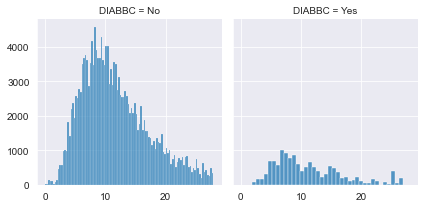

In [26]:
g = sns.FacetGrid(new_data_ZINCT, col="DIABBC")
g.map_dataframe(sns.histplot, x="ZINCT1")

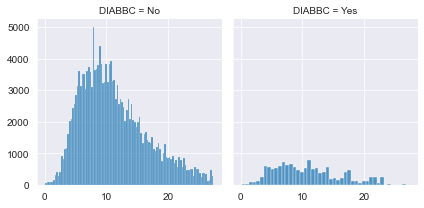

In [27]:
g = sns.FacetGrid(new_data_ZINCT, col="DIABBC")
g.map_dataframe(sns.histplot, x="ZINCT2")

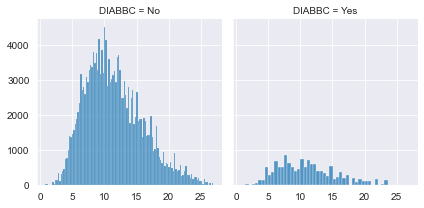

In [28]:
g = sns.FacetGrid(new_data_ZINCT, col="DIABBC")
g.map_dataframe(sns.histplot, x="ZINCT_MEAN")

## EDA: Important variable Sex

From the Distribution of ZINCT_MEAN conditional on Diabetes and Sex, we can see that: 

- **The dirtribution of ZINCT_MEAN conditional on Sex is different!** 
- The distribution of Male(sex = 1) in both healthy and diabete group are symmetry, while the distributions of Female (sex = 2) are right skewed, which imply that the mode/mean of Zn in female group is lower than male. 
- Thus, there is relationship between Sex, Zn and diabetes.
## causal influence，partial independence 需要加在这里！！！因为三个variable的关系并不确定

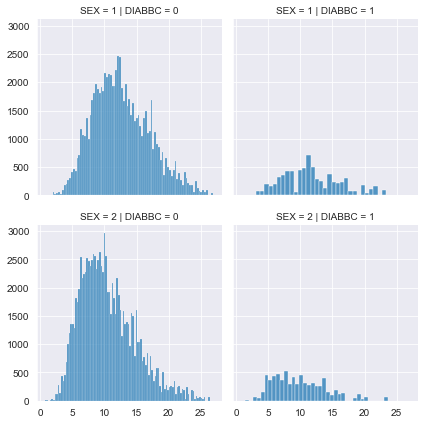

In [16]:
g = sns.FacetGrid(new_data_ZINCT, col="DIABBC",  row="SEX")
g.map_dataframe(sns.histplot, x="ZINCT_MEAN")

## EDA T test: on the mean of Zn (healthy group VS diabete gruop)

> T- Test :- A t-test is a type of inferential statistic which is used to determine if there is a significant difference between the means of two groups which may be related in certain features.

>  Two sampled T-test :-The Independent Samples t Test or 2-sample t-test compares the means of two independent groups in order to determine whether there is statistical evidence that the associated population means are significantly different.

- H0: The mean of Zn in healthy group (Diabbc = 0) and diabete gruop (Diabbc = 1) are the same
- H1: The mean of Zn in two groups are different
- **Our testing is based on the data removing the missing value, and mean of the tow columns**
- If the p_value < 0.05, it means that the mean of two groups are different
- From the values below, we can see that the mean of two groups are statistically different since (p_value < 0.05)

In [38]:
from scipy.stats import ttest_ind

diabetes_group = new_data_ZINCT[new_data_ZINCT1['DIABBC']==1]
healthy_group = new_data_ZINCT[new_data_ZINCT1['DIABBC']==5]



print("Mean of healthy group of ZINCT1:", np.mean(healthy_group['ZINCT1']))
print("Mean of diabetes group of ZINCT1:", np.mean(diabetes_group['ZINCT1']))
print("T test on the ZINCT1:")
print(ttest_ind(diabetes_group['ZINCT1'], healthy_group['ZINCT1']))



print("\nMean of healthy group of ZINCT2:", np.mean(healthy_group['ZINCT2']))
print("Mean of diabetes group of ZINCT2:", np.mean(diabetes_group['ZINCT2']))
print("T test on the ZINCT2:")
print(ttest_ind(diabetes_group['ZINCT2'], healthy_group['ZINCT2']))

print("\nMean of healthy group of ZINCT_MEAN:", np.mean(healthy_group['ZINCT_MEAN']))
print("Mean of diabetes group of ZINCT_MEAN:", np.mean(diabetes_group['ZINCT_MEAN']))
print("T test on the ZINCT_MEAN:")
print(ttest_ind(diabetes_group['ZINCT_MEAN'], healthy_group['ZINCT_MEAN']))

Mean of healthy group of ZINCT1: 11.727630477063556
Mean of diabetes group of ZINCT1: 11.189306695624573
T test on the ZINCT1:
Ttest_indResult(statistic=-10.786967658084365, pvalue=4.037367974784837e-27)

Mean of healthy group of ZINCT2: 11.259002909715415
Mean of diabetes group of ZINCT2: 10.786820399714147
T test on the ZINCT2:
Ttest_indResult(statistic=-9.774824473014103, pvalue=1.4614552395160844e-22)

Mean of healthy group of ZINCT_MEAN: 11.49331669338949
Mean of diabetes group of ZINCT_MEAN: 10.98806354766936
T test on the ZINCT_MEAN:
Ttest_indResult(statistic=-12.65381780395426, pvalue=1.1017792710573974e-36)


# Vegan indicator
- `PLYTGM`: Poultry, total (g)
- `MTTLGM`: Meats, poultry and alternatives, ADG criteria (g)
- `MTTNGM`: Meats, poultry and alternatives, non-ADG criteria (discretionary) (g)
- `FISHSRV`: Fish and seafood (serves)

For red meat (MTTLGM, MTTNGM(nutr)), poultry (PLYTGM(nutr)), and fish(FISHSRV(nutr)). 
    Where 0 intake of either/each = vegetarian/ vegan 
    
### Findings:
Under Vegan indacator, only 17 ppl are vegan, and 1 of them has diabetes. Too less sample.

# Red Meat indicator
- `MEAT1N`: Meat, poultry (serves/day)

For red meat (MEAT1N(nutr)) 
    Where 0 intake of either/each = vegetarian/ vegan 
    
### Findings:

**The no red meat group has less risk to get diabetes, compared to the group eating red meat**:
    - Under Red Meat indicator, 5.3% diabetes in the group "no-red meat eating", 7% diabetes in the group "eating red meat"

In [89]:
def label_vegan(row):
    """
    For red meat (MTTLGM, MTTNGM(nutr)), poultry (PLYTGM(nutr)), and fish(FISHSRV(nutr)). 
    Where 0 intake of either/each = vegetarian/ vegan 
    """
    if row["PLYTGM"] == 0 and row["MTTLGM"] == 0 and row["MTTNGM"] == 0 and row["FISHSRV"] == 0:
        return 1
    else:
        return 0
    
    
def label_red_meat(row):
    """
    For red meat (MEAT1N(nutr)) 
    Where 0 intake of either/each = vegetarian/ vegan 
    """
    if row["MEAT1N"] == 0:
        return 0
    else:
        return 1

In [90]:
new_data_ZINCT['Vegan_indicator'] = new_data_ZINCT.apply (lambda row: label_vegan(row), axis=1)
new_data_ZINCT['RedMeat_indicator'] = new_data_ZINCT.apply (lambda row: label_red_meat(row), axis=1)

In [ ]:
groupByPPL = new_data_ZINCT.groupby(['ABSPID']).min() 

In [88]:
# Table of survival vs. sex
sub_table = pd.crosstab(index=groupByPPL["Vegan_indicator"], 
                           columns=groupByPPL["DIABBC"],
                           margins=True) # Include row and column totals

sub_table.columns = ["Diabetes group","Healthy group", "rowTotal"]


sub_table

,Diabetes group,Healthy group,rowTotal
Vegan_indicator,,,
0,374,5108,5482
1,1,16,17
All,375,5124,5499


In [93]:
groupByPPL = new_data_ZINCT.groupby(['ABSPID']).max() 

In [96]:
# Table of survival vs. sex
sub_table = pd.crosstab(index=groupByPPL["RedMeat_indicator"], 
                           columns=groupByPPL["DIABBC"],
                           margins=True) # Include row and column totals

sub_table.columns = ["Diabetes group","Healthy group", "rowTotal"]


sub_table

,Diabetes group,Healthy group,rowTotal
RedMeat_indicator,,,
0,28,504,532
1,347,4620,4967
All,375,5124,5499


In [97]:
sub_table.T/sub_table["rowTotal"]

RedMeat_indicator,0,1,All
Diabetes group,0.053,0.070,0.068
Healthy group,0.947,0.930,0.932
rowTotal,1.000,1.000,1.000


#  Eating type

`COMBCODE`: Food combination type

### Vege group 
- COMBCODE	4. Salad
- COMBCODE	9. Vegetables with additions
- COMBCODE	10. Fruit with additions

### Meat/Protein group
- COMBCODE	12. Meat, poultry, fish

### Carbohydrate group
- COMBCODE	11. Tortilla products
- COMBCODE	3. Bread/baked products with additions
- COMBCODE	2. Cereal with additions


### Mixed eating group 
- COMBCODE	5. Sandwiches/wraps/rolls with fillings

### Junk food group
- COMBCODE	14. Chips
- COMBCODE	8. Ice cream/frozen yoghurt with additions

### Other
- COMBCODE	6. Soup
- COMBCODE	1. Beverage with additions
- COMBCODE	7. Frozen meal

In [61]:
def label_race(row):
    if row['COMBCODE'] == 4 or row['COMBCODE'] == 9 or row['COMBCODE'] == 10:
        return 'Vege'
    elif row['COMBCODE'] == 12:
        return 'Protein'
    elif row['COMBCODE'] == 11 or row['COMBCODE'] == 3 or row['COMBCODE'] == 2:
        return "Carbohydrate"
    elif row['COMBCODE'] == 5:
        return "Mixed"
    elif row['COMBCODE'] == 14 or row['COMBCODE'] == 8:
        return "JunkFood"
    return 'Other'

In [62]:
new_data_ZINCT['EatingType'] = new_data_ZINCT.apply (lambda row: label_race(row), axis=1)

In [98]:
# Table of survival vs. sex
sub_table = pd.crosstab(index=new_data_ZINCT["EatingType"], 
                           columns=new_data_ZINCT["DIABBC"],
                           margins=True) # Include row and column totals

sub_table.columns = ["Diabetes group","Healthy group", "rowTotal"]


sub_table

,Diabetes group,Healthy group,rowTotal
EatingType,,,
Carbohydrate,2168,25317,27485
JunkFood,34,467,501
Mixed,1298,17904,19202
Other,9150,125567,134717
Protein,335,4731,5066
Vege,501,7202,7703
All,13486,181188,194674


In [99]:
sub_table.T/sub_table["rowTotal"]

EatingType,Carbohydrate,JunkFood,Mixed,Other,Protein,Vege,All
Diabetes group,0.079,0.068,0.068,0.068,0.066,0.065,0.069
Healthy group,0.921,0.932,0.932,0.932,0.934,0.935,0.931
rowTotal,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Relationship between DIETRDI(Whether vegetable and fruit consumption met recommended guidelines) and DIABBC

- DIETRDI = 0: missing value
- DIETRDI = 1: Met recommended guidelines
- DIETRDI = 2: Did not meet recommended guidelines


From the table below, we can see that:
1. For the group "Met recommended guidelines", 91% are health, 9% are currently diabetes
2. For the group "Did not meet recommended guidelines", 93% are heathy, 7% are currently diatetes. 

Thus, **DIETRDI(Whether vegetable and fruit consumption met recommended guidelines) cannot help our analsis**. There are possible reasons:
1. Whether met vegetable and fruit consumption guide has no relation with diabetes
2. The diabetes group change their eating habits after they suffer from diabetes
3. "Response bias": the ppl didnot give the true answer (e.g. trend to think they met the guidelines but actually not)
4. "Selection bias": the ppl who joined this survey are more likely to have diabetes. 

In [85]:
groupByPPL = new_data_ZINCT.groupby(['ABSPID']).mean()

In [78]:
# Table of survival vs. sex
sub_table = pd.crosstab(index=groupByPPL["DIETRDI"], 
                           columns=groupByPPL["DIABBC"],
                           margins=True) # Include row and column totals

sub_table.columns = ["Diabetes group","Healthy group", "rowTotal"]

sub_table.index= ["Met recommended guidelines",
                   "Did not meet recommended guidelines",
                     "colTotal"]

sub_table

,Diabetes group,Healthy group,rowTotal
Met recommended guidelines,28,278,306
Did not meet recommended guidelines,347,4846,5193
colTotal,375,5124,5499


In [79]:
sub_table.T/sub_table["rowTotal"]

,Met recommended guidelines,Did not meet recommended guidelines,colTotal
Diabetes group,0.092,0.067,0.068
Healthy group,0.908,0.933,0.932
rowTotal,1.000,1.000,1.000


## Save the data with selected columns

In [104]:
output_col = ["DIABBC",  "AGEC","SEX", "INCDEC", "EXLWTBC", "BMISC", "DIETRDI","ZINCT_MEAN", "EatingType", 
                "COMBCODE", "Vegan_indicator", "RedMeat_indicator", "SELT_MEAN"]

In [105]:
new_data_ZINCT[output_col].to_csv('data/selected_columns_14Oct.csv', index=False)